In [105]:
# Imports

import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [106]:
# Define the folder path
data_path = "data/"

# Load datasets
zero_coupon = pd.read_csv(os.path.join(data_path, "zero_coupon_rates.csv"), delimiter=";")
exchange_rates = pd.read_csv(os.path.join(data_path, "usd_nok.csv"), delimiter=";")
inflation = pd.read_csv(os.path.join(data_path, "kpi.csv"), delimiter=";")
osebx = pd.read_csv(os.path.join(data_path, "osebx_prices.csv"), delimiter=";")

# Replace commas with dots in the KPI column and convert to float
inflation["kpi"] = inflation["kpi"].str.replace(",", ".").astype(float)


In [107]:
# Check missing values
print(osebx.isnull().sum())
print(zero_coupon.isnull().sum())
print(exchange_rates.isnull().sum())
print(inflation.isnull().sum())


Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
FREQ           0
Frequency      0
TENOR          0
Tenor          0
DECIMALS       0
TIME_PERIOD    0
OBS_VALUE      0
dtype: int64
FREQ                    0
Frequency               0
BASE_CUR                0
Base Currency           0
QUOTE_CUR               0
Quote Currency          0
TENOR                   0
Tenor                   0
DECIMALS                0
CALCULATED              0
UNIT_MULT               0
Unit Multiplier         0
COLLECTION              0
Collection Indicator    0
TIME_PERIOD             0
OBS_VALUE               0
dtype: int64
Date    0
kpi     0
dtype: int64


No missing values

In [108]:
# Convert Date to Datetime format
osebx["Date"] = pd.to_datetime(osebx["Date"])
zero_coupon["TIME_PERIOD"] = pd.to_datetime(zero_coupon["TIME_PERIOD"])
exchange_rates["TIME_PERIOD"] = pd.to_datetime(exchange_rates["TIME_PERIOD"])
inflation["Date"] = pd.to_datetime(inflation["Date"], format="%YM%m")

print(inflation.head())

        Date    kpi
0 2015-03-01   99.2
1 2015-04-01   99.6
2 2015-05-01   99.8
3 2015-06-01  100.1
4 2015-07-01  100.1


In [109]:
# Create a full date range from the first to last available date in your dataset
full_date_range = pd.date_range(start=inflation["Date"].min(), end=inflation["Date"].max(), freq="D")

# Create a DataFrame with daily dates
inflation_daily = pd.DataFrame({"Date": full_date_range})

# Merge with the original inflation data (left join) and forward-fill missing values
inflation_daily = inflation_daily.merge(inflation, on="Date", how="left")
inflation_daily["kpi"] = inflation_daily["kpi"].fillna(method="ffill")  # Forward-fill missing values

print(inflation_daily.head())  # Check results


        Date   kpi
0 2015-03-01  99.2
1 2015-03-02  99.2
2 2015-03-03  99.2
3 2015-03-04  99.2
4 2015-03-05  99.2


In [110]:
# Compute log returns
osebx["log_return"] = np.log(osebx["Close"] / osebx["Close"].shift(1))
osebx.dropna(inplace=True)  # Drop the first row where return cannot be calculated

# Rename columns to "Date"
zero_coupon.rename(columns={"TIME_PERIOD": "Date"}, inplace=True)
exchange_rates.rename(columns={"TIME_PERIOD": "Date"}, inplace=True)

# Merge all datasets on 'Date'
df = inflation_daily.merge(zero_coupon, on="Date", how="inner")
df = df.merge(exchange_rates, on="Date", how="inner")
df = df.merge(osebx, on="Date", how="inner") 

print(df.head())  # Check final dataset

        Date   kpi FREQ_x Frequency_x TENOR_x   Tenor_x  DECIMALS_x  \
0 2015-03-03  99.2      B    Business     10Y  10 years           3   
1 2015-03-04  99.2      B    Business     10Y  10 years           3   
2 2015-03-05  99.2      B    Business     10Y  10 years           3   
3 2015-03-06  99.2      B    Business     10Y  10 years           3   
4 2015-03-09  99.2      B    Business     10Y  10 years           3   

   OBS_VALUE_x FREQ_y Frequency_y  ... Unit Multiplier COLLECTION  \
0        1.540      B    Business  ...           Units          C   
1        1.546      B    Business  ...           Units          C   
2        1.567      B    Business  ...           Units          C   
3        1.639      B    Business  ...           Units          C   
4        1.676      B    Business  ...           Units          C   

              Collection Indicator OBS_VALUE_y       Close        High  \
0  ECB concertation time 14:15 CET      7.7091  616.919983  617.729980   
1  ECB con

In [111]:
df = df.drop(columns=["Close", "High", "Low", "Open", "Volume",
       "FREQ_x", "Frequency_x", "TENOR_x", "Tenor_x", "DECIMALS_x",
       "FREQ_y", "Frequency_y", "BASE_CUR", "Base Currency",
       "QUOTE_CUR", "Quote Currency", "TENOR_y", "Tenor_y", "DECIMALS_y",
       "CALCULATED", "UNIT_MULT", "Unit Multiplier", "COLLECTION",
       "Collection Indicator"])

df.rename(columns={"OBS_VALUE_x": "zero_coupon_rate"}, inplace=True)
df.rename(columns={"OBS_VALUE_y": "usd_nok_exchange_rate"}, inplace=True)

print(df.head())

        Date   kpi  zero_coupon_rate  usd_nok_exchange_rate  log_return
0 2015-03-03  99.2             1.540                 7.7091    0.005967
1 2015-03-04  99.2             1.546                 7.7441   -0.012511
2 2015-03-05  99.2             1.567                 7.7207    0.011992
3 2015-03-06  99.2             1.639                 7.7917    0.002769
4 2015-03-09  99.2             1.676                 7.8992   -0.006572


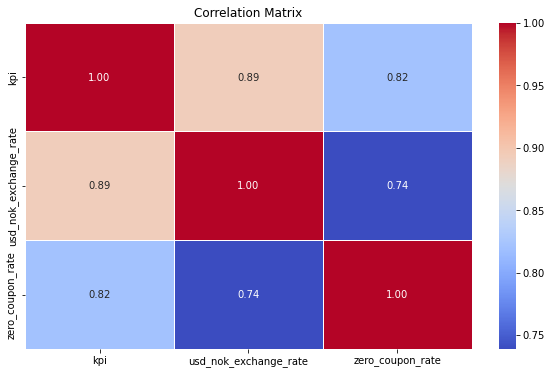

In [112]:
# Compute the correlation matrix

selected_columns = ["kpi", "usd_nok_exchange_rate", "zero_coupon_rate"]
corr_matrix = df[selected_columns].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


We define highly correlated values to have a correlation coefficient >0.9. Because all variables have a correlation coefficient below 0.9, we decide to keep all of the explanatory variables. However, we notice that especially between usd_nok_exchange_rate and kpi and between zero_coupon_rate and kpi the coefficient is close to the boundary. 

In [113]:
# Check for stationarity 

from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-stationary")

# Test all relevant variables
adf_test(df["log_return"])
adf_test(df["zero_coupon_rate"])  # Replace with actual column name
adf_test(df["usd_nok_exchange_rate"])  # Replace with actual column name
adf_test(df["kpi"])  # Replace with actual column name


ADF Statistic: -15.867838902915956
p-value: 9.054142897534569e-29
Stationary
ADF Statistic: -0.5795020392460742
p-value: 0.875546784604051
Non-stationary
ADF Statistic: -1.4185188293291202
p-value: 0.5733664669247795
Non-stationary
ADF Statistic: 0.9028597537112383
p-value: 0.9931275336262437
Non-stationary


In [114]:
# Transform to stationary variables

# Apply first differences
df["d_kpi"] = df["kpi"].diff()
df["d_zero_coupon_rate"] = df["zero_coupon_rate"].diff()
df["d_usd_nok_exchange_rate"] = df["usd_nok_exchange_rate"].diff()

# Drop NaN values created by differencing (first row)
df = df.dropna()

adf_test(df["d_zero_coupon_rate"])  # Replace with actual column name
adf_test(df["d_usd_nok_exchange_rate"])  # Replace with actual column name
adf_test(df["d_kpi"])  # Replace with actual column name

ADF Statistic: -45.80666001847484
p-value: 0.0
Stationary
ADF Statistic: -50.867422752534345
p-value: 0.0
Stationary
ADF Statistic: -50.2883609437652
p-value: 0.0
Stationary


In [115]:
print(df.head())

        Date   kpi  zero_coupon_rate  usd_nok_exchange_rate  log_return  \
1 2015-03-04  99.2             1.546                 7.7441   -0.012511   
2 2015-03-05  99.2             1.567                 7.7207    0.011992   
3 2015-03-06  99.2             1.639                 7.7917    0.002769   
4 2015-03-09  99.2             1.676                 7.8992   -0.006572   
5 2015-03-10  99.2             1.748                 8.0457   -0.017672   

   d_kpi  d_zero_coupon_rate  d_usd_nok_exchange_rate  
1    0.0               0.006                   0.0350  
2    0.0               0.021                  -0.0234  
3    0.0               0.072                   0.0710  
4    0.0               0.037                   0.1075  
5    0.0               0.072                   0.1465  
